In [1]:
# Load data:
# from util.Dataloader import Dataloader
# from preprocessing import Preprocessing
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# # Concatenate:
# dataloader00 = Dataloader('/MI_Jake_00')
# eeg_data00, eeg_labels00 = dataloader00.get_data()

# dataloader01 = Dataloader('/MI_Jake_01')
# eeg_data01, eeg_labels01 = dataloader01.get_data()

# dataloader02 = Dataloader('/MI_Jake_02')
# eeg_data02, eeg_labels02 = dataloader02.get_data()

# dataloader03 = Dataloader('/MI_Jake_03')
# eeg_data03, eeg_labels03 = dataloader03.get_data()

# eeg_data = np.concatenate((eeg_data00, eeg_data01, eeg_data02, eeg_data03), axis=1)
# print(eeg_data.shape)

# eeg_labels = np.concatenate((eeg_labels00, eeg_labels01, eeg_labels02, eeg_labels03), axis=0)
# print(eeg_labels.shape)



In [2]:
DATA_DIR = Path('./data')
eeg_data = np.load(DATA_DIR / 'Sandra_MI_1h_eeg_data.npy', allow_pickle=True)
eeg_labels = np.load(DATA_DIR / 'Sandra_MI_1h_marker_stream.npy', allow_pickle=True)

In [3]:
print(eeg_labels.shape)
print(eeg_data.shape)

(1023780,)
(8, 1023780)


# Etract Trials from event_stream
would be better if the event_time_steps can be used here

- 'beep': 0,
- 'cue_no_blink': 1,
- 'imagery_no_blink': 2,
- 'break': 3,
- 'cue_handR': 4,
- 'imagery_handR': 5,
- 'cue_handL': 6,
- 'imagery_handL': 7

In [4]:
sample_rate = 250
nchannels, nsamples = eeg_data.shape
channel_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

#  classes we want to separate and their respective codings from above
cl1 = 'left'
cl2 = 'right'
coding1 = 7 # imagery_handL
coding2 = 5 # imagery_handR

def get_onsets(labels):
    onsets = []
    event_codes = []
    for i in range(len(eeg_labels)-1):
        if eeg_labels[i]-eeg_labels[i+1] != 0:
            onsets.append(i+1)
            event_codes.append(eeg_labels[i+1])
    return np.asarray(onsets), np.asarray(event_codes)  

# Dictionary to store the trials
trials = {}
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))
nsamples_per_trial = len(win)
onsets, event_codes = get_onsets(eeg_labels)

for cl, event in zip([cl1, cl2], [coding1,coding2]): #handl and handR
    class_onsets = onsets[event_codes == event]       
            
    # Allocate memory for trials of class
    trials[cl] = np.zeros((nchannels, nsamples_per_trial, len(class_onsets)))
    
    for i, onset in enumerate(class_onsets):
        trials[cl][:,:,i] = eeg_data[:, win+onset]
        
# Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[left]:', trials[cl1].shape)
print('Shape of trials[right]:', trials[cl2].shape)


Shape of trials[left]: (8, 500, 200)
Shape of trials[right]: (8, 500, 200)


# Plotting PSD 

In [5]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.  
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, sample_rate+1, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples_per_trial), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs


In [6]:
# Apply the function
psd_r, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

In [7]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().
    
    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd() 
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = np.ceil(nchans / 3)
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


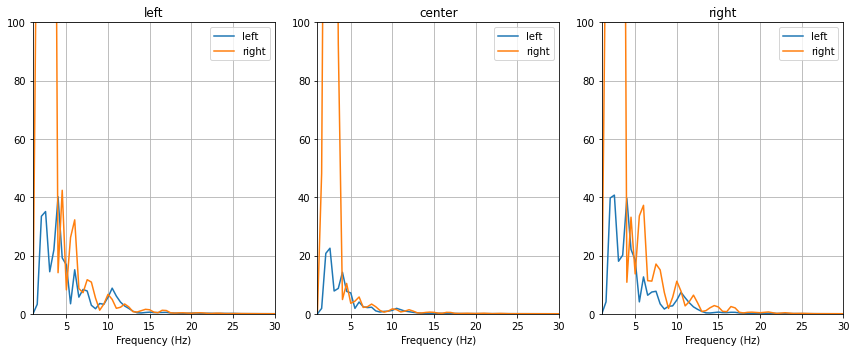

In [8]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=100  # problem: orders of magnitude
)

# Apply bandpass filter

In [9]:
import scipy.signal 

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)
    
    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''
    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples_per_trial, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


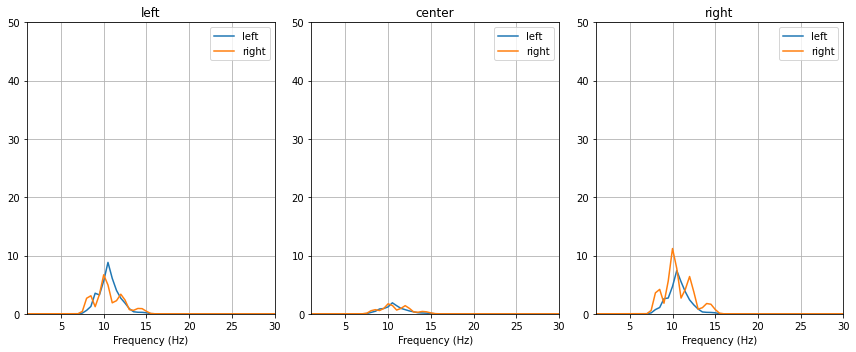

In [10]:
# Apply bandpass function
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}
# plot the result
psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD2 = {cl1: psd_r, cl2: psd_f}

plot_psd(
    trials_PSD2,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=50 # problem: orders of magnitude
)

# Compute logvar

No handles with labels found to put in legend.


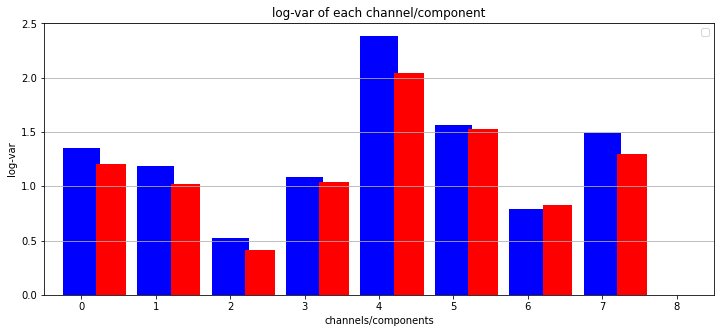

In [11]:
# Calculate the log(var) of the trials

def logvar(trials):
    '''
    Calculate the log-var of each channel.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.
        
    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))

# Apply the function
trials_logvar = {cl1: logvar(trials_filt[cl1]),
                 cl2: logvar(trials_filt[cl2])}

def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend()

plot_logvar(trials_logvar)


# Apply CSP algorithm

No handles with labels found to put in legend.


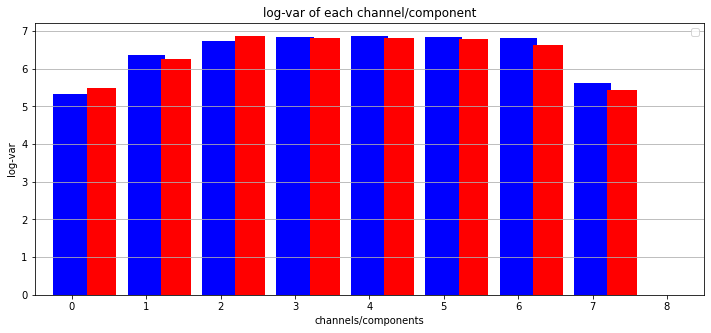

In [16]:
from numpy import linalg

def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples_per_trial, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

# Apply the functions
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}


trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
ipykernel_launcher:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


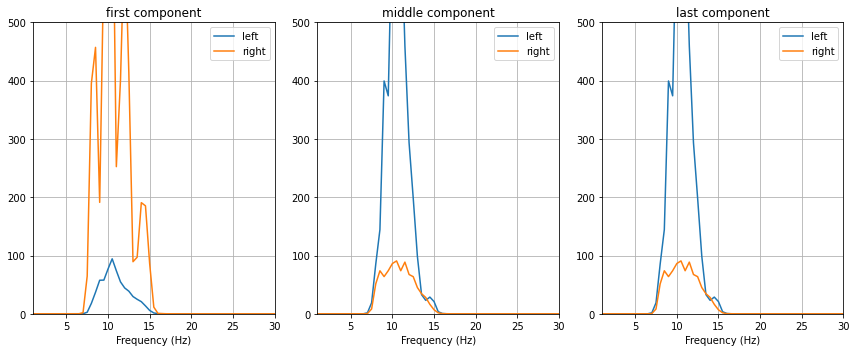

In [21]:
psd_r, freqs = psd(trials_csp[cl1])
psd_f, freqs = psd(trials_csp[cl2])
trials_PSD2 = {cl1: psd_r, cl2: psd_f}

plot_psd(trials_PSD2, freqs, [0,7,-1], chan_lab=['first component', 'middle component', 'last component'], maxy=500 )

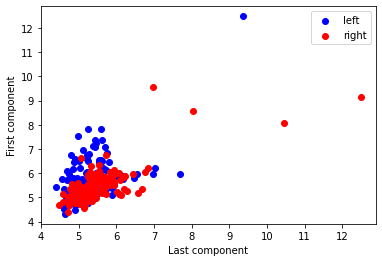

In [23]:
def plot_scatter(left, right):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b', label = cl1)
    plt.scatter(right[0,:], right[-1,:], color='r', label = cl2)
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend()

plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [24]:
# Percentage of trials to use for training (50-50 split here)
train_percentage = 0.75

# Calculate the number of trials for each class the above percentage boils down to
ntrain_r = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[cl2].shape[2] * train_percentage)
ntest_r = trials_filt[cl1].shape[2] - ntrain_r
ntest_f = trials_filt[cl2].shape[2] - ntrain_f

# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt[cl1][:,:,:ntrain_r],
         cl2: trials_filt[cl2][:,:,:ntrain_f]}

test = {cl1: trials_filt[cl1][:,:,ntrain_r:],
        cl2: trials_filt[cl2][:,:,ntrain_f:]}

# Train the CSP on the training set only
W = csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

# Select only the first and last components for classification
comp = np.array([0,-1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]

# Calculate the log-var
train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl1] = logvar(test[cl1])
test[cl2] = logvar(test[cl2])

In [25]:
def train_lda(class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    # Class priors: in this case, we have an equal number of training
    # examples for each class, so both priors are 0.5
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    # Calculate the covariance between the features
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (features x trials) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing a classlabel for each trial
    '''
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):
        # The line below is a generalization for:
        # result = W[0] * test[0,i] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [26]:
W,b = train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

plt.show()

W: [ 0.23503784 -0.95914042]
b: -5.6758815391433926


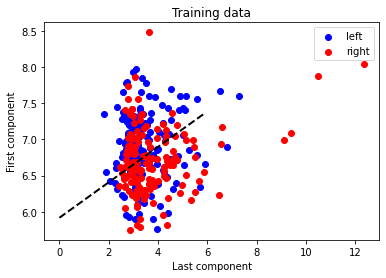

In [30]:
# Scatterplot like before
plot_scatter(train[cl1], train[cl2])
plt.title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(0, 6, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
#plt.xlim(-5, 1)
#plt.ylim(-2.2, 1)

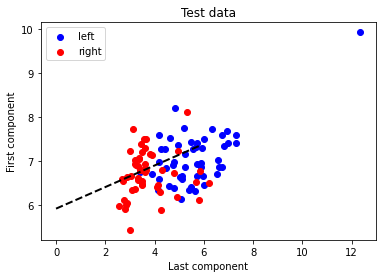

In [31]:
plot_scatter(test[cl1], test[cl2])
plt.title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
#plt.xlim(-5, 1)
#plt.ylim(-2.2, 1)

In [32]:
conf = np.array([
    [(apply_lda(test[cl1], W, b) == 1).sum(), (apply_lda(test[cl2], W, b) == 1).sum()],
    [(apply_lda(test[cl1], W, b) == 2).sum(), (apply_lda(test[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[16 23]
 [34 27]]

Accuracy: 0.430
